Evaluated on 3706 problems having ground-truth similar questions.
Average Precision@10: 0.0451
Average Recall@10:    0.1990
Average NDCG@10:      0.2208


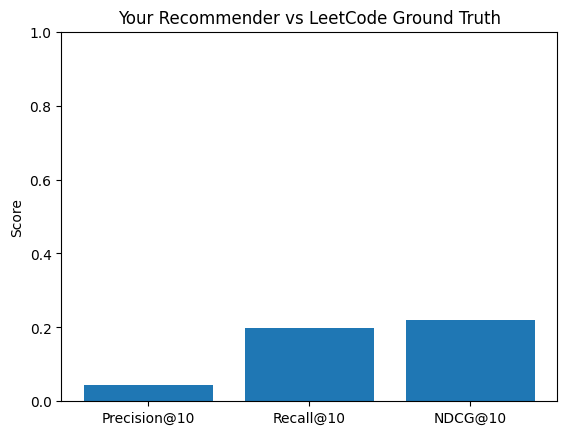

In [39]:
import pandas as pd
import numpy as np
import re, ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# -------------------- LOAD DATA --------------------
df = pd.read_csv("../Data_Pipeline/preprocessed_data.csv")

# -------------------- CLEAN TITLES & GROUND TRUTH --------------------
def clean_title(text):
    text = str(text).lower().strip()
    text = re.sub(r'^\d+\.\s*', '', text)           # remove leading "123. "
    text = re.sub(r'[^a-z0-9\s]', '', text)         # remove punctuation
    text = re.sub(r'\s+', ' ', text)                # normalize spaces
    return text.strip()

def parse_similar(x):
    try:
        if isinstance(x, str):
            lst = ast.literal_eval(x)
            return [clean_title(i) for i in lst]
        return []
    except Exception:
        return []

df['clean_title'] = df['title'].apply(clean_title)
df['ground_truth'] = df['similar_questions'].apply(parse_similar)

# -------------------- TF-IDF VECTORIZATION --------------------
df['topic_tags'] = df['topic_tags'].fillna('').astype(str)
df['combined_text'] = (
    df['title'].astype(str) + " " +
    df['difficulty'].astype(str) + " " +
    df['topic_tags'].astype(str)
)

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['combined_text'])

# -------------------- RECOMMENDATION FUNCTION --------------------
def get_recommendations(idx, k=10):
    sim_scores = cosine_similarity(X[idx], X).flatten()
    sim_scores[idx] = 0  # exclude self
    top_idx = sim_scores.argsort()[-k:][::-1]
    return [df.iloc[i]['clean_title'] for i in top_idx]

# -------------------- METRIC FUNCTIONS --------------------
def precision_recall_at_k(pred, truth, k=10):
    if not truth:
        return None, None
    pred_k = pred[:k]
    hits = len(set(pred_k) & set(truth))
    prec = hits / len(pred_k)
    rec = hits / len(truth)
    return prec, rec

def ndcg_at_k(pred, truth, k=10):
    rel = [1 if item in truth else 0 for item in pred[:k]]
    if not any(rel):
        return 0.0
    dcg = sum(r / np.log2(i+2) for i, r in enumerate(rel))
    idcg = sum(sorted(rel, reverse=True)[i] / np.log2(i+2) for i in range(len(rel)))
    return dcg / idcg

# -------------------- EVALUATION LOOP --------------------
precisions, recalls, ndcgs = [], [], []
tested = 0

for i in range(len(df)):
    gt = df.loc[i, 'ground_truth']
    if not gt:
        continue
    pred = get_recommendations(i, 10)
    p, r = precision_recall_at_k(pred, gt, 10)
    n = ndcg_at_k(pred, gt, 10)
    if p is not None:
        precisions.append(p)
        recalls.append(r)
        ndcgs.append(n)
        tested += 1

print(f"Evaluated on {tested} problems having ground-truth similar questions.")
print(f"Average Precision@10: {np.mean(precisions):.4f}")
print(f"Average Recall@10:    {np.mean(recalls):.4f}")
print(f"Average NDCG@10:      {np.mean(ndcgs):.4f}")

# -------------------- VISUALIZE --------------------
plt.bar(['Precision@10','Recall@10','NDCG@10'],
        [np.mean(precisions), np.mean(recalls), np.mean(ndcgs)])
plt.title("Your Recommender vs LeetCode Ground Truth")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()
